# Data Wrangling

Download labels from: http://www.tamaraberg.com/street2shop/wheretobuyit/  
Paper: http://www.cs.unc.edu/~xufeng/cs/papers/iccv15-wheretobuyit.pdf

This dataset contains exact street2shop pairs and the retrieval sets for 11 clothing categories: bags, belts, dresses, eyewear, footwear, hats, leggings, outerwear, pants, skirts, tops

"To study Exact Street to Shop at large scale, we collected and labeled a dataset of 20,357 images of clothing worn by
people in the real world,  and 404,483 images of clothing from shopping websites.  The dataset contains 39,479 pairs
of exactly matching items worn in street photos and shown in shop images."  
  
  
*M. Hadi Kiapour, Xufeng Han, Svetlana Lazebnik, Alexander C. Berg, Tamara L. Berg. Where to Buy It: Matching Street Clothing Photos in Online Shops. International Conference on Computer Vision (ICCV), 2015.*

**For this project all images have been already download and resized. Due to some broken links the total number of images retrieved will be 383,169**

In [1]:
import os
import re
import random
import pandas as pd
import numpy as np
from PIL import Image
import sys
import joblib #save/load objects
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cv2
import shutil
%matplotlib inline
plt.style.use('seaborn')

Files are separated into 3 classes: retrieval, train and test. Each of these classes have a json for each of the 11 clothing categories.  

The function below merges all categories json files under the 3 classes, then train and test are also merged so we can do a custom data split.

In [2]:
path_labels = "../labels"
def format_labels(path_labels, shop_images=False):
    
    json_files = os.listdir(path_labels)
    json_files = [os.path.join(path_labels, file) for file in json_files] #reading in all json files
    if shop_images==False:
        all_files = [file for file in json_files if "retrieval" in file]
    else:
        all_files = [file for file in json_files if ("train" in file) | ("test" in file)]
    
    files_df = pd.DataFrame()
    for file in all_files:
        files_df = files_df.append(pd.read_json(file))
    
    category_files = [file.split("_")[-1].split(".json")[0] for file in all_files]
    print("Categories: ", category_files)

    category_nrows = [pd.read_json(file).shape[0] for file in all_files]
    print("Categories number of rows: ", category_nrows)
    
    files_df["category"] = ""
    for n, category in enumerate(category_files):
        if n == 0:
            files_df["category"].iloc[0:category_nrows[0]] = category
        index_0 = sum(category_nrows[:n])
        index_1 = sum(category_nrows[:n+1])
        files_df["category"].iloc[index_0:index_1] = category
    files_df = files_df.reset_index(drop=True)
    
    files_df["id"] = files_df["product"].astype(str) + "_" + files_df["category"] #creating key for pair matching
    
    if shop_images == True:
        files_df["bbox"] = files_df["bbox"].apply(lambda x: {k:v for k, v in sorted(x.items())}) #fixes missalignment in label order
        files_df["bbox"] = files_df["bbox"].apply(lambda x: "".join(map(lambda x: str(x) + ",", list(x.values()))))

        bboxes = files_df["bbox"].str.split(",",expand=True).drop(columns=[4])
        bboxes.columns=(["height", "left", "top", "width"])
        files_df = pd.concat([files_df,bboxes], axis=1).drop(columns=["bbox"])
        return files_df
    return files_df

In [3]:
retrieval_df = format_labels(path_labels)
customer_df = format_labels(path_labels, shop_images=True)

Categories:  ['bags', 'belts', 'dresses', 'eyewear', 'footwear', 'hats', 'leggings', 'outerwear', 'pants', 'skirts', 'tops']
Categories number of rows:  [16319, 1252, 169941, 1595, 75853, 2551, 8228, 34744, 7641, 18295, 68478]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Categories:  ['bags', 'belts', 'dresses', 'eyewear', 'footwear', 'hats', 'leggings', 'outerwear', 'pants', 'skirts', 'tops', 'bags', 'belts', 'dresses', 'eyewear', 'footwear', 'hats', 'leggings', 'outerwear', 'pants', 'skirts', 'tops']
Categories number of rows:  [174, 89, 3292, 138, 2178, 86, 517, 666, 130, 604, 763, 579, 235, 12875, 358, 6486, 400, 1641, 1945, 600, 3337, 2173]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Retrieval: Images without a blank background

After performing a visual check of the photos downloaded we realised that some of the retrieval images are not useful for the purpose of this project as they are not clothes, just remnants of them. These can be easily identified due to not having a blank background. Examples shown below.

In [4]:
img_path = "../photos_resized/"
example_img = "19472.jpg"
example_img_2 = "89745.jpg"
example_img_wrong = "19591.jpg"
example_images = [example_img, example_img_2, example_img_wrong]

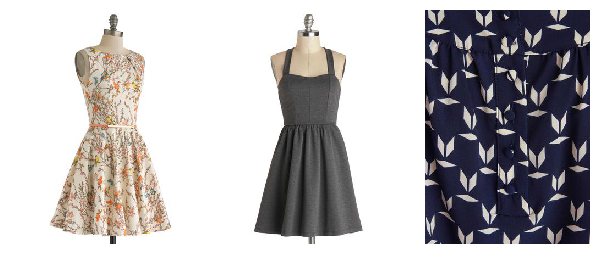

In [5]:
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(1, len(example_images))

for n, i in enumerate(example_images):
    ax = fig.add_subplot(gs[0, n])
    ax.imshow(Image.open(img_path+i))
    ax.axis("off")
plt.show()

Image "19591.jpg" was spotted as an example, so we will proceed to look for more images like this one and remove them from the sets.

In order to find these images the strategy we will follow will be to read every image in the folder and extract a small rectangle composed of the first 10x100 pixels with its numeric representation, we will then aggregate the resulting array and compare it to the array of a correct example.

In [6]:
def square_sample(img_path, img, x, y):
    """
    This function allows us to select a region of the image we want to convert to an array
    Just specify the x and y coordinates in a list format i.e x=[0,10], y=[0,10]
    """
    img_read = cv2.imread(img_path+img)
    img_sum = 0

    for line in img_read[y[0]:y[1]]:
        img_sum += line[x[0]:x[1]].sum()
        
    return img_sum

In [7]:
print("Sum of the first 10*100 pixels of the image:")
print("Correct_img_1", square_sample(img_path, example_img, [0,10], [0,100]))
print("Correct_img_2", square_sample(img_path, example_img_2, [0,10], [0,100]))
print("Wrong_img    ", square_sample(img_path, example_img_wrong, [0,10], [0,100]))

threshold = 700000

Sum of the first 10*100 pixels of the image:
Correct_img_1 765000
Correct_img_2 764751
Wrong_img     202869


Images 1 and 2 are both correct, however the sum of the elements of the second one are slightly different. This could be caused by a very light grey pixel, therefore we have decided to use 700,000 as a threshold so it gives a little bit of margin when filtering images. Any sum of elements below this threshold will be classified as a wrong image.

In [8]:
# read images and sort them in alphanumeric
list_pics = os.listdir(img_path)
list_pics = sorted(list_pics, key = lambda x: int(re.sub("(\\D)", "", x)))

# we only need to read retrieval images
mask_retr = pd.Series(list_pics).isin(retrieval_df['photo'].map(lambda x: str(x)+".jpg"))
list_pics = np.array(list_pics)[mask_retr]

In [9]:
def read_imgs(img_path, list_pics, x, y):
    """
    Return an array with the sum of the elements of each image
    """
    img_arrays = []
    with tqdm(total=len(list_pics), file=sys.stdout) as pbar:
        for n, img in enumerate(list_pics):
            img_sum = square_sample(img_path, img, x=x, y=y)
            img_arrays.append(img_sum)
            pbar.set_description("done: %d" % (1 + n))
            pbar.update(1)
    return np.array(img_arrays)

The function to read all images takes around 20 min to complete. To avoid waiting such a long time please load the *.pkl  object with the resulting array that has been previously saved.

In [ ]:
%%time
imgs_sum_wrong = read_imgs(img_path, list_pics, [0,10], [0,100])
joblib.dump(imgs_sum_wrong, "./pkl_objects/imgs_sum_wrong.pkl")

In [10]:
imgs_sum_wrong = joblib.load("./pkl_objects/imgs_sum_wrong.pkl")

In [11]:
wrong_images = list_pics[imgs_sum_wrong < threshold]
print("Number of wrong images:", len(wrong_images))

Number of wrong images: 41696


After identifying all wrong images we will copy a sample of them into a new folder for a quick visual exploration to ensure that no correct images are deleted.

In [13]:
img_path_check = "../photos_check"
os.makedirs(img_path_check, exist_ok=True)

In [ ]:
sample = 1000
wrong_sample = [random.choice(wrong_images) for i in range(sample)]

for img in tqdm(wrong_sample):
    shutil.copy(os.path.join(img_path, img), os.path.join(img_path_check, img))

Once we are confident of excluding these wrong images we will save them in a list without the *.jpg extension so they can be removed from the retrieval dataframe

In [14]:
shutil.rmtree(img_path_check, ignore_errors=True) # removing temporary folder
wrong_images = [img.split('.')[0] for img in wrong_images]

## Retrieval: Empty images

We have also identified that some images are empty and show the message "Image Not Available"

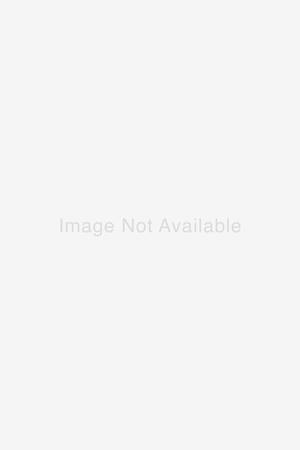

In [15]:
empty_img = "192741.jpg"
Image.open(img_path+empty_img)

Image "192741.jpg" was spotted as an example, so we will proceed to look for more images like this one and remove them from the sets. These images come from corrupted links when retrieving images from stores.  

We will follow the same strategy as before, but in this case the threshold will be the exact number of the sum of the pixels as we want to find all same images.

In [16]:
print("Sum of 20*20 pixels from the centre of the image:")
print("Empty_img ", square_sample(img_path, empty_img, [140,160], [220,240]))

threshold = square_sample(img_path, empty_img, [140,160], [220,240])

Sum of 20*20 pixels from the centre of the image:
Empty_img  290007


In [ ]:
%%time # ~20 min to run. Please load the pkl object below
imgs_sum_empty = read_imgs(img_path, list_pics, [140,160], [220,240])
#joblib.dump(imgs_sum_empty, "./pkl_objects/imgs_sum_empty.pkl")

In [17]:
imgs_sum_empty = joblib.load("./pkl_objects/imgs_sum_empty.pkl")

In [18]:
empty_images = np.array(list_pics)[imgs_sum_empty == threshold]
print("Number of blank images:", len(empty_images))

Number of blank images: 1353


We will now copy all empty images to our "photos_check" folder for visual exploration

In [ ]:
os.makedirs(img_path_check, exist_ok=True)

for img in tqdm(empty_images):
    shutil.copy(os.path.join(img_path, img), os.path.join(img_path_check, img))

Once we are confident of excluding these empty images we will save them in a list without the *.jpg extension so they can be removed from the retrieval dataframe

In [19]:
shutil.rmtree(img_path_check, ignore_errors=True) #delete temporary folder
empty_images = [img.split('.')[0] for img in empty_images]

## Removing all broken links, wrong and not available images
Broken links and corrupted images are saved on the missing images csv. We will remove them along with the wrong and not available images.

In [21]:
all_missing = pd.read_csv("./missing_images.csv")
print("Missing images:", len(all_missing))
print("Wrong images:  ", len(wrong_images))
print("Blank images:  ", len(empty_images))

Missing images: 43072
Wrong images:   41696
Blank images:   1353


In [22]:
customer_df = customer_df[~customer_df["photo"].isin(all_missing["photo"])]
retrieval_df = retrieval_df[~retrieval_df["photo"].isin(all_missing["photo"])]
retrieval_df = retrieval_df[~retrieval_df["photo"].isin(wrong_images)]
retrieval_df = retrieval_df[~retrieval_df["photo"].isin(empty_images)]

Removing customer images that do not have a pair match since their actual matches may have been removed now

In [23]:
print("Total customer images: ", customer_df.shape[0])
customer_available = customer_df[customer_df["id"].isin(retrieval_df["id"])]
print("Total matches: ", customer_available.shape[0])

Total customer images:  39261
Total matches:  28175


In [24]:
retrieval_df.to_csv("retrieval_df.csv", index=False)
customer_available.to_csv("customer_df.csv", index=False)